<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/vito/STEP_4A_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [1]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 106 (delta 8), reused 6 (delta 6), pack-reused 88 (from 1)
Receiving objects: 100% (106/106), 19.31 MiB | 29.74 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Mounted at /content/drive


In [3]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [4]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [19]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

IGNORE_INDEX = -1

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 5

GAMMA = 0.5

LR = 1e-3

LR_D = 1e-5

LAMBDA_ADV_TARGET = 1

P = 0.5 # probabilità augmentation

# Define and instantiate

### Define PIDnet

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

# Define Discriminator
Used for the adversarial approach

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class FCDiscriminator(nn.Module):

	def __init__(self, num_classes, ndf = 64):
		super(FCDiscriminator, self).__init__()

		self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)
		self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)
		self.classifier = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=1)

		self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)


	def forward(self, x):
		x = self.conv1(x)
		x = self.leaky_relu(x)
		x = self.conv2(x)
		x = self.leaky_relu(x)
		x = self.conv3(x)
		x = self.leaky_relu(x)
		x = self.conv4(x)
		x = self.leaky_relu(x)
		x = self.classifier(x)

		return x

def initialize_weights_kaiming(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.zeros_(m.bias)

# Dataset & dataloader

## Dataset definition

In [23]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, target=False, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augmentation = augmentation
        self.target = target

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])


        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


        if self.augmentation:
          transformed = self.augmentation(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]


        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        # if the dataset is a target dataset, does not return the mask
        if self.target == True:
          return image, boundaries_tensor
        return image, mask, boundaries_tensor

In [24]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2



resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

# the bast augmentation from previous step is chosen
gaussian_blur = A.GaussianBlur(p=P, sigma_limit=(0.5, 3.0))

## Dataset instantiation

In [25]:
# Create dataset objects

# TRAINING DATASETS
source_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                    transform=resize_transform, augmentation=gaussian_blur)


target_dataset = SegmentationDataset(TRAINING_PATH_RURAL + "/images_png", TRAINING_PATH_RURAL + "/masks_png",
                                    transform=resize_transform, target=True, augmentation=gaussian_blur)

# EVALUATION DATASET

val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

## Loader instantiation

In [26]:
# Create DataLoaders

# TRAINING DATALOADERS
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# EVALUATION DATALOADERS

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# enumerate dataloaders
source_loader_iter = enumerate(source_loader)
target_loader_iter = enumerate(target_loader)


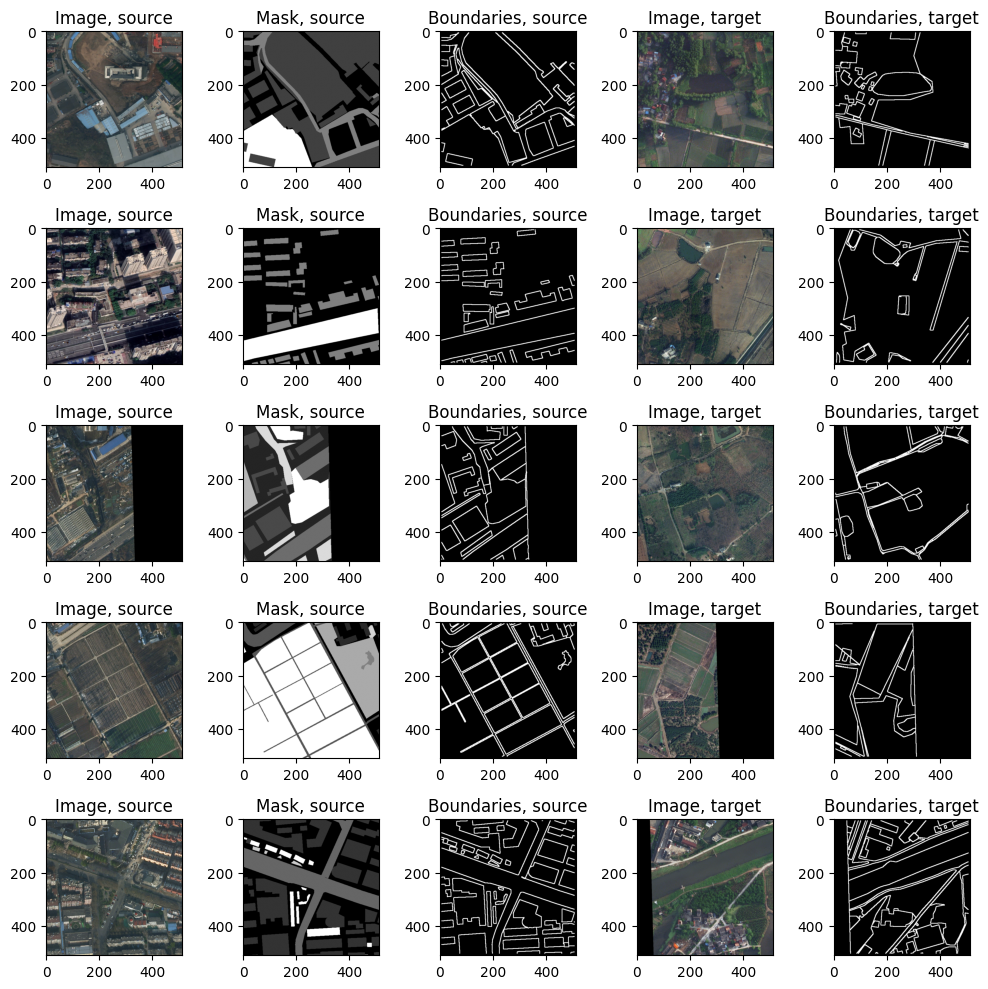

In [27]:
from utils import show
from matplotlib import pyplot as plt

source_batch = next(iter(source_loader))  # (images, masks, boundaries)
target_batch = next(iter(target_loader))  # (images, masks, boundaries)
images_s, masks_s, boundaries_s = source_batch  # Unpack the source batch
images_t, boundaries_t = target_batch  # Unpack the target batch

fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(5):  # Show first 3 images

    # VISUALIZE SOURCE SAMPLES
    # Permute the dimensions of the image tensor to (height, width, channels)
    image_s_np = images_s[i].cpu().numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image_s_np) # Display the image with the correct shape
    axes[i, 0].set_title("Image, source")

    axes[i, 1].imshow(masks_s[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask, source")

    axes[i, 2].imshow(boundaries_s[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries, source")

    # VISUALIZE TARGET SAMPLES
    image_t_np = images_t[i].cpu().numpy().transpose(1, 2, 0)
    axes[i, 3].imshow(image_t_np) # Display the image with the correct shape
    axes[i, 3].set_title("Image, target")

    axes[i, 4].imshow(boundaries_t[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 4].set_title("Boundaries, target")


plt.tight_layout()
plt.show()

### Instantiate model

In [28]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)

# Training Phase

## Define loss functions

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, num_outputs, weight=None, balance_weights=[0.4, 1.0], sb_weights=1.0):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=IGNORE_INDEX)
        self.num_outputs = num_outputs
        self.balance_weights = balance_weights
        self.sb_weights = sb_weights

    def _forward(self, pred, target):
        return self.loss(pred, target)

    def forward(self, score, target):

        if self.num_outputs == 1:
            score = [score]

        if len(self.balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(self.balance_weights, score)])
        elif len(score) == 1:
            return self.sb_weights * self._forward(score[0], target)
        else:
            raise ValueError("lengths of prediction and target are not identical!")


# Weighted Binary Cross Entropy per i bordi
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

class BondaryLoss(nn.Module):
    def __init__(self, coeff_bce = 20.0):
        super(BondaryLoss, self).__init__()
        self.coeff_bce = coeff_bce

    def forward(self, bd_pre, bd_gt):

        bce_loss = self.coeff_bce * weighted_bce(bd_pre, bd_gt)
        loss = bce_loss

        return loss

# PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.sem_loss = CrossEntropyLoss(num_outputs=2, balance_weights=[lambda_0, lambda_2], sb_weights=lambda_3)
        self.bd_loss = BondaryLoss(coeff_bce=lambda_1)

        self.threshold = threshold


    def forward(self, pred_p, pred_main, target, boundary_head, boundary_mask):
        """
        pred_p: output branch P (B, C, H, W)
        pred_main: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """

        loss_s = self.sem_loss([pred_p, pred_main], target) # l_0 e l_2
        loss_b = self.bd_loss(boundary_head, boundary_mask.unsqueeze(1)) # l_1

        # l_3
        filler = torch.ones_like(target) * IGNORE_INDEX
        bd_label = torch.where(F.sigmoid(boundary_head[:,0,:,:])>self.threshold, target, filler)
        loss_sb = self.sem_loss([pred_main], bd_label)


        loss = loss_s + loss_b + loss_sb


        return loss

## Upscaling function

In [30]:
import torch.nn.functional as F

def Upscaling(outputs, boundary_mask, model):
    """Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
    Quindi passiamo da 64 x 64 della rete a 512 x 512"""

    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)
    if model.augment:
        pred_p, pred_main, boundary_head = outputs  # P, I, D branches
    else:
        pred_p = None
        pred_main = outputs
        boundary_head = None  # Nessuna branch D se augment=False

    return pred_p, pred_main, boundary_head

## Instantiate discriminator, optimizers and schedulers

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_D = FCDiscriminator(num_classes=NUM_CLASSES)
#model_D.apply(initialize_weights_kaiming)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=LR_D)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# TODO: vedere risultati usando torch.nn.MSELoss()
bce_loss = torch.nn.BCEWithLogitsLoss()

loss_fn = PIDNetLoss(threshold=0.8)

print(device)

cuda


## Train

[0.001]


73it [00:25,  2.87it/s]


Epoch 1/20 | Total train samples seen: 1156 | model lr: [0.001]
  → Segmentation Source Loss : 0.9884
  → Segmentation Target Loss : 0.04406007
  → Discriminator Loss       : 0.0875


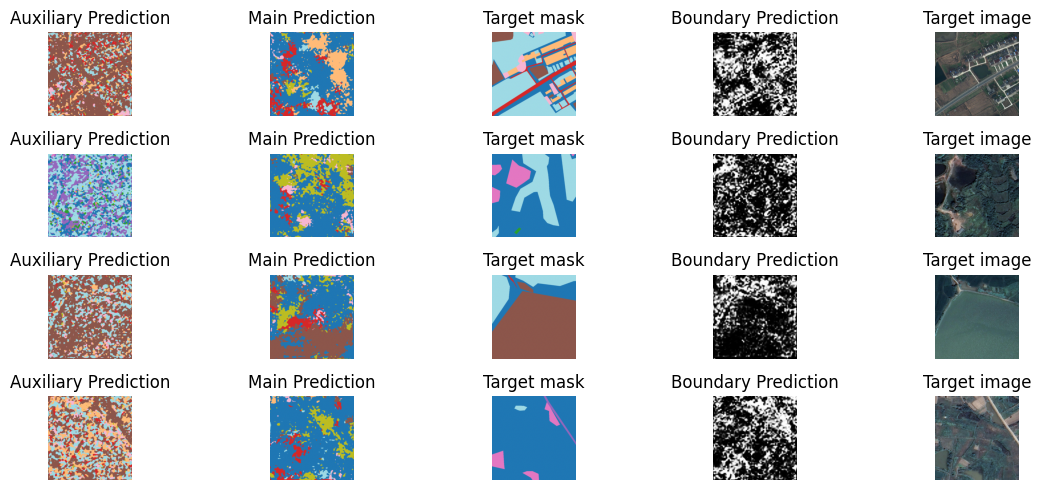

Epoch 1/20 | Validation Loss: 0.7661064247931203 | mIoU: 0.16733381152153015 | Total validation samples seen: 992
  → background IoU: 0.3736
  → building IoU: 0.1728
  → road IoU: 0.0361
  → water IoU: 0.0791
  → barren IoU: 0.0210
  → forest IoU: 0.0589
  → agriculture IoU: 0.0412


73it [00:25,  2.86it/s]


Epoch 2/20 | Total train samples seen: 1156 | model lr: [0.001]
  → Segmentation Source Loss : 0.6261
  → Segmentation Target Loss : 0.04509456
  → Discriminator Loss       : 0.0866


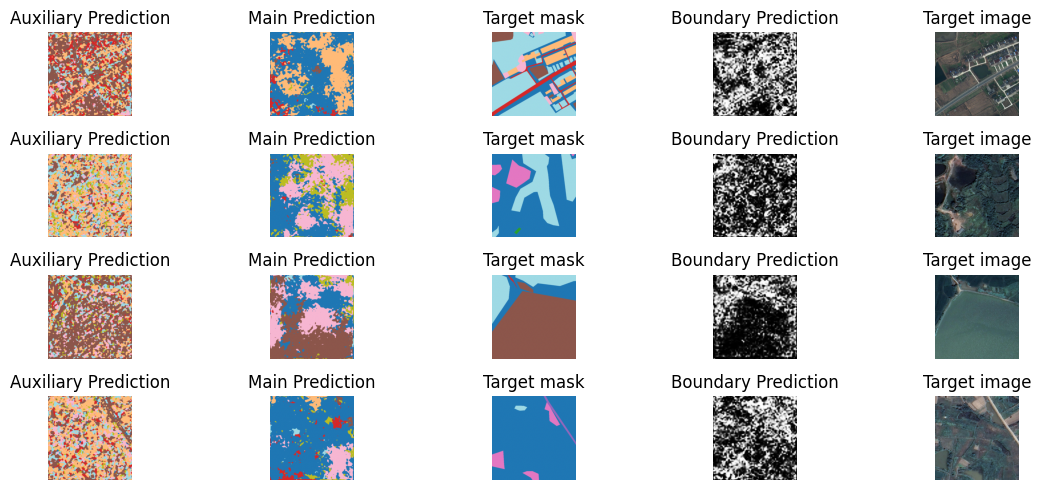

Epoch 2/20 | Validation Loss: 0.5897859642582555 | mIoU: 0.15683411061763763 | Total validation samples seen: 992
  → background IoU: 0.3612
  → building IoU: 0.1532
  → road IoU: 0.0619
  → water IoU: 0.1047
  → barren IoU: 0.0197
  → forest IoU: 0.0647
  → agriculture IoU: 0.0314


73it [00:25,  2.87it/s]


Epoch 3/20 | Total train samples seen: 1156 | model lr: [0.001]
  → Segmentation Source Loss : 0.4793
  → Segmentation Target Loss : 0.04524246
  → Discriminator Loss       : 0.0865


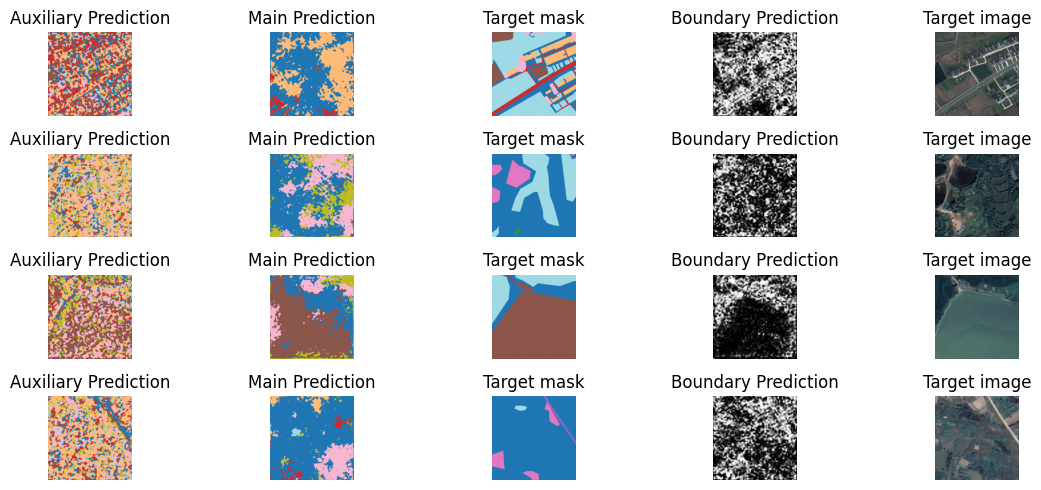

Epoch 3/20 | Validation Loss: 0.5210876440809619 | mIoU: 0.1363026648759842 | Total validation samples seen: 992
  → background IoU: 0.3648
  → building IoU: 0.1404
  → road IoU: 0.0870
  → water IoU: 0.1281
  → barren IoU: 0.0190
  → forest IoU: 0.0719
  → agriculture IoU: 0.0162


73it [00:25,  2.84it/s]


Epoch 4/20 | Total train samples seen: 1156 | model lr: [0.001]
  → Segmentation Source Loss : 0.4238
  → Segmentation Target Loss : 0.04477040
  → Discriminator Loss       : 0.0868


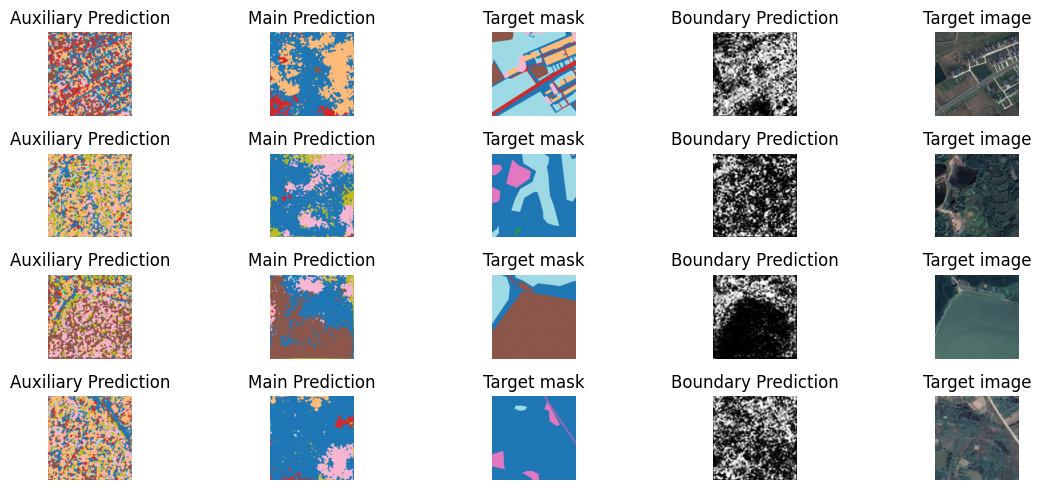

Epoch 4/20 | Validation Loss: 0.48908863288740956 | mIoU: 0.13952122628688812 | Total validation samples seen: 992
  → background IoU: 0.3818
  → building IoU: 0.1518
  → road IoU: 0.0888
  → water IoU: 0.1558
  → barren IoU: 0.0193
  → forest IoU: 0.0663
  → agriculture IoU: 0.0206


73it [00:25,  2.88it/s]


Epoch 5/20 | Total train samples seen: 1156 | model lr: [0.001]
  → Segmentation Source Loss : 0.3897
  → Segmentation Target Loss : 0.04445142
  → Discriminator Loss       : 0.0870


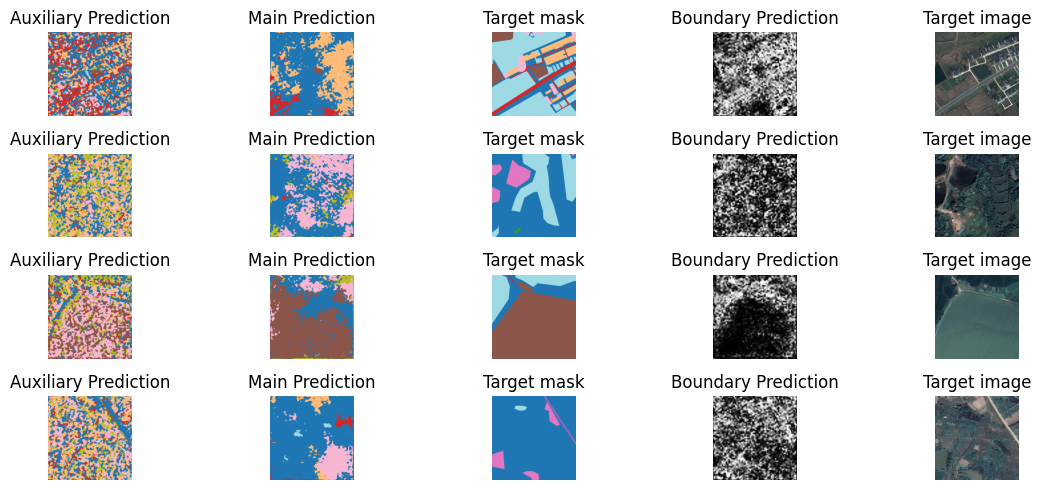

Epoch 5/20 | Validation Loss: 0.45499817690541666 | mIoU: 0.11968518793582916 | Total validation samples seen: 992
  → background IoU: 0.3801
  → building IoU: 0.1366
  → road IoU: 0.1050
  → water IoU: 0.1502
  → barren IoU: 0.0161
  → forest IoU: 0.0500
  → agriculture IoU: 0.0141


73it [00:25,  2.87it/s]


Epoch 6/20 | Total train samples seen: 1156 | model lr: [0.0005]
  → Segmentation Source Loss : 0.3776
  → Segmentation Target Loss : 0.04370606
  → Discriminator Loss       : 0.0873


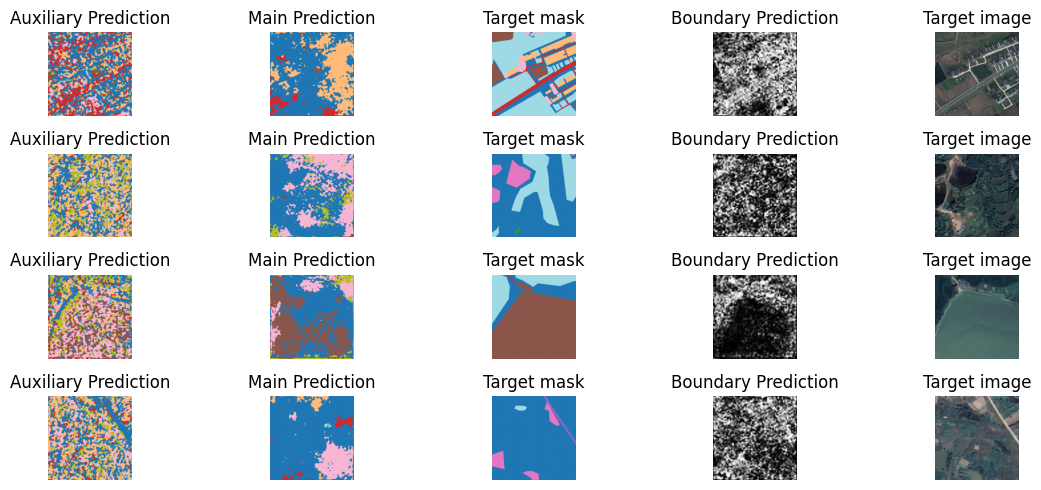

Epoch 6/20 | Validation Loss: 0.44299548047204174 | mIoU: 0.12115756422281265 | Total validation samples seen: 992
  → background IoU: 0.3825
  → building IoU: 0.1579
  → road IoU: 0.1109
  → water IoU: 0.1123
  → barren IoU: 0.0181
  → forest IoU: 0.0640
  → agriculture IoU: 0.0143


73it [00:25,  2.84it/s]


Epoch 7/20 | Total train samples seen: 1156 | model lr: [0.0005]
  → Segmentation Source Loss : 0.3646
  → Segmentation Target Loss : 0.04396173
  → Discriminator Loss       : 0.0870


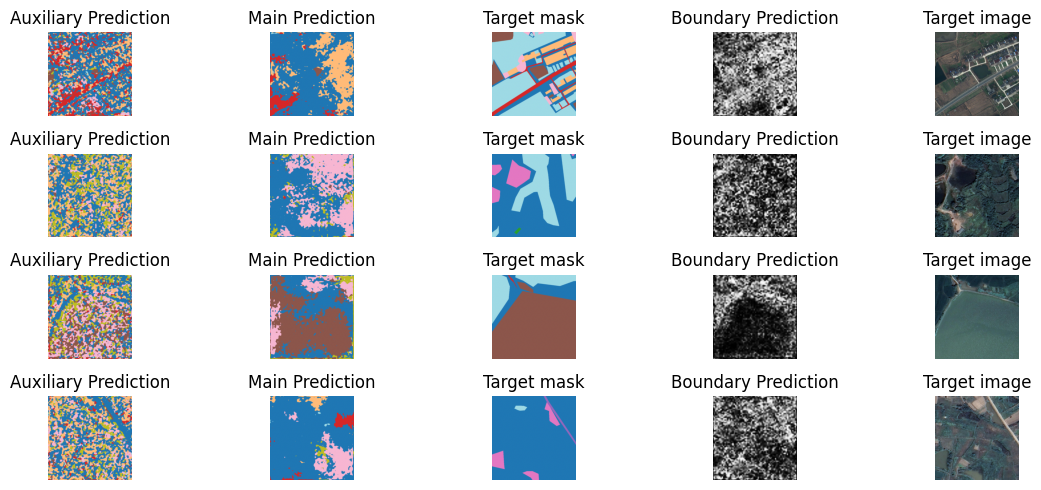

Epoch 7/20 | Validation Loss: 0.42710438803319006 | mIoU: 0.11056322604417801 | Total validation samples seen: 992
  → background IoU: 0.3897
  → building IoU: 0.1627
  → road IoU: 0.1199
  → water IoU: 0.1288
  → barren IoU: 0.0142
  → forest IoU: 0.0540
  → agriculture IoU: 0.0075


13it [00:05,  2.19it/s]


KeyboardInterrupt: 

In [32]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

def file_exists(modelID):
    path = f"/content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_3B_{modelID}.pth"
    return os.path.exists(path)

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

source_label = 0
target_label = 1

model.to(device)
model_D.to(device)

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)
miou_overall = MeanIoU(num_classes=num_classes).to(device)

print(scheduler.get_last_lr())

for epoch in range(EPOCHS):

    # ****************************** Training ******************************

    # losses for epoch
    loss_seg_source_value = 0 # loss for the segmentation model (source)
    loss_adv_target_value = 0 # loss for the segmentation model (target)
    loss_D_value = 0

    total_train_samples = 0

    model.train()
    model_D.train()

    for i, (source_batch, target_batch) in tqdm(enumerate(zip(source_loader, target_loader))):

        optimizer.zero_grad()
        optimizer_D.zero_grad()

        # train G

        # don't accumulate grads in D
        for param in model_D.parameters():
            param.requires_grad = False

        # train with source

        X, y, boundary_mask = source_batch
        X = X.to(device)
        y = y.to(device)
        boundary_mask = boundary_mask.to(device)

        outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

        # Calcolo della loss
        loss = loss_fn(pred_p, pred_main, y, boundary_head, boundary_mask)

        loss.backward()

        loss_seg_source_value += loss.item()

        # train with target

        X_target, boundary_mask_target = target_batch
        X_target = X_target.to(device)
        boundary_mask_target = boundary_mask_target.to(device)

        outputs_target = model(X_target)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

        pred_p_target, pred_main_target, boundary_head_target = Upscaling(outputs=outputs_target, boundary_mask=boundary_mask_target, model=model)

        D_out = model_D(F.softmax(pred_main_target, dim=1))

        loss_adv = bce_loss(D_out,
                            torch.FloatTensor(D_out.data.size()).fill_(source_label).to(device))

        loss = loss_adv * LAMBDA_ADV_TARGET

        loss.backward()

        loss_adv_target_value += loss.item()

        # train D

        # bring back requires_grad
        for param in model_D.parameters():
            param.requires_grad = True

        # train with source
        pred_main = pred_main.detach()

        D_out = model_D(F.softmax(pred_main, dim=1))

        loss_D = bce_loss(D_out,
                              torch.FloatTensor(D_out.data.size()).fill_(source_label).to(device))
        loss_D.backward()

        loss_D_value += loss_D.item()

        # train with target
        pred_main_target = pred_main_target.detach()

        D_out = model_D(F.softmax(pred_main_target, dim=1))

        loss_D = bce_loss(D_out,
                              torch.FloatTensor(D_out.data.size()).fill_(target_label).to(device))
        loss_D.backward()

        loss_D_value += loss_D.item()

        # step both optimizers
        optimizer.step()
        optimizer_D.step()

        total_train_samples += X.size(0)

    avg_loss_seg_source = loss_seg_source_value / total_train_samples
    avg_loss_seg_target = loss_adv_target_value / total_train_samples
    avg_loss_D = loss_D_value / total_train_samples

    print(f"Epoch {epoch+1}/{EPOCHS} | Total train samples seen: {total_train_samples} | model lr: {scheduler.get_last_lr()}")
    print(f"  → Segmentation Source Loss : {avg_loss_seg_source:.4f}")
    print(f"  → Segmentation Target Loss : {avg_loss_seg_target:.8f}")
    print(f"  → Discriminator Loss       : {avg_loss_D:.4f}")


    # ****************************** Validazione ******************************
    model.eval()
    val_loss = 0
    miou_classes.reset()
    miou_overall.reset()
    total_val_samples = 0

    with torch.inference_mode():
        for batch, (X_val, y_val, boundary_mask) in enumerate(val_loader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            boundary_mask = boundary_mask.to(device)

            # Output del modello
            outputs = model(X_val)

            #upscaling
            pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

            if batch == 0:
              fig, axs = plt.subplots(4, 5, figsize=(12, 5))

              for j in range(4):

                axs[j, 0].imshow(pred_p[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
                axs[j, 0].set_title("Auxiliary Prediction")
                axs[j, 0].axis('off')

                axs[j, 1].imshow(pred_main[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
                axs[j, 1].set_title("Main Prediction")
                axs[j, 1].axis('off')

                axs[j, 2].imshow(y_val[j].cpu().detach().numpy(), cmap='tab20')
                axs[j, 2].set_title("Target mask")
                axs[j, 2].axis('off')

                axs[j, 3].imshow(boundary_head[j].cpu().detach().sigmoid().squeeze(0).numpy(), cmap='gray')
                axs[j, 3].set_title("Boundary Prediction")
                axs[j, 3].axis('off')

                axs[j, 4].imshow(X_val[j].cpu().detach().squeeze(0).numpy().transpose(1, 2, 0))
                axs[j, 4].set_title("Target image")
                axs[j, 4].axis('off')

              plt.tight_layout()
              plt.show()

            # Calcola la loss
            loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)
            val_loss += loss.item()

            total_val_samples += X_val.size(0)

            # Calcola le predizioni
            preds = pred_main.argmax(dim=1)  # Shape: (N, H, W)

            # Mask dei pixel validi (classi da 0 a num_classes - 1)
            valid_mask = (y_val >= 0) & (y_val < num_classes)

            # Appiattisci le predizioni e i target solo sui pixel validi
            preds_flat = preds[valid_mask]
            targets_flat = y_val[valid_mask]

            miou_classes.update(preds_flat, targets_flat)
            miou_overall.update(preds_flat, targets_flat)

    avg_val_loss = val_loss / total_val_samples

    miou_per_class = miou_classes.compute()
    miou = miou_overall.compute()

    print(f"Epoch {epoch+1}/{EPOCHS} | Validation Loss: {avg_val_loss} | mIoU: {miou} | Total validation samples seen: {total_val_samples}")
    # per class
    for i, iou in enumerate(miou_per_class):
        class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
        print(f"  → {class_name} IoU: {iou:.4f}")

    scheduler.step()


In [ ]:
# ****************************** Validazione ******************************
model.eval()
val_loss = 0
miou_classes.reset()
miou_overall.reset()
total_val_samples = 0

with torch.inference_mode():
    for batch, (X_val, y_val, boundary_mask) in enumerate(val_loader):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        #upscaling
        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)
        print("pred_main shape:", pred_main.shape)
        print("pred_main unique classes:", torch.argmax(pred_main, dim=1).unique())


        if batch == 0:
          fig, axs = plt.subplots(4, 5, figsize=(12, 5))

          for j in range(4):

            axs[j, 0].imshow(pred_p[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 0].set_title("Auxiliary Prediction")
            axs[j, 0].axis('off')

            axs[j, 1].imshow(pred_main[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 1].set_title("Main Prediction")
            axs[j, 1].axis('off')

            axs[j, 2].imshow(y_val[j].cpu().detach().numpy(), cmap='tab20')
            axs[j, 2].set_title("Target mask")
            axs[j, 2].axis('off')

            axs[j, 3].imshow(boundary_head[j].cpu().detach().sigmoid().squeeze(0).numpy(), cmap='gray')
            axs[j, 3].set_title("Boundary Prediction")
            axs[j, 3].axis('off')

            axs[j, 4].imshow(X_val[j].cpu().detach().squeeze(0).numpy().transpose(1, 2, 0))
            axs[j, 4].set_title("Target image")
            axs[j, 4].axis('off')

          plt.tight_layout()
          plt.show()

        # Calcola la loss
        loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)
        val_loss += loss.item()

        total_val_samples += X_val.size(0)

        # Calcola le predizioni
        preds = pred_main.argmax(dim=1)  # Shape: (N, H, W)

        # Mask dei pixel validi (classi da 0 a num_classes - 1)
        valid_mask = (y_val >= 0) & (y_val < num_classes)

        # Appiattisci le predizioni e i target solo sui pixel validi
        preds_flat = preds[valid_mask]
        targets_flat = y_val[valid_mask]

        miou_classes.update(preds_flat, targets_flat)
        miou_overall.update(preds_flat, targets_flat)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou_classes.compute()
miou = miou_overall.compute()

print(f"Epoch {epoch+1}/{EPOCHS} | Validation Loss: {avg_val_loss} | mIoU: {miou} | Total validation samples seen: {total_val_samples}")
# per class
for i, iou in enumerate(miou_per_class):
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f"  → {class_name} IoU: {iou:.4f}")

## Evaluation

In [ ]:
import torch

def load_inference_pidnet_model(id: int, name: str):
    """Returns the inference PIDNet model with `id`, it has to be saved in `content/drive/MyDrive/AML_project/checkpoints/`."""

    model = get_pred_model(name=name, num_classes=7)
    try:
        saved_weights = torch.load(
            f"content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_3B_{id}.pth",
            map_location=torch.device("cpu")
        )
    except FileNotFoundError:
        raise ValueError("This model was not found")

    model.load_state_dict(saved_weights)
    return model

### Salvataggio del modello su drive

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_urban.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

In [ ]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    print(f"h: {h} | w: {w} | ph: {ph} | pw: {pw}")
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")


In [ ]:
"""
 # **Validazione**
model.eval()
val_loss = 0
miou.reset()

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        # Converte le predizioni nei valori di classe più probabili
        preds = torch.argmax(pred_main, dim=1)


        target_one_hot = F.one_hot(y_val+1, num_classes=num_classes+1)

        target_one_hot = target_one_hot[:, :, :, 1:] -1 # Shape: [8, 16, 16, 7]

        # Permute to get (N, C, H, W)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).bool()


        pred_miou = F.one_hot(pred_main.argmax(dim=1), num_classes=num_classes).permute(0, 3, 1, 2).to(torch.bool)  # Shape: [8, 7, 16, 16]
        #avg_miou = pred_main.mean()

        # Converte le predizioni nei valori di classe più probabili
        #preds = torch.argmax(pred_main, dim=1)

        miou.update(preds=pred_miou, target=target_one_hot)

        # Calcola la loss
        loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou.compute()  # Returns a tensor with per-class IoU
miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
print(f"Validation Loss: {avg_val_loss} - avg mIoU: {avg_miou} - mIoU per class: {miou_per_class_str}")
"""